# Simple ELO 
In this notebook, I explore the application of a simple ELO calculation to the historical NFL data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 

%matplotlib inline

In [3]:
data_dir = os.path.abspath('../data')
print(f'Loading data from {data_dir}..')

Loading data from C:\Users\dmris\Documents\Python Scripts\elo_ratings\nfl-ratings\data..


Let's load the data and apply some simple filters, based on the exploration.  I have decided to exclude matches before 1960, when the league expanded.

In [9]:
data = pd.read_csv(f'{data_dir}/historical_data.csv')
data = data[np.logical_not(
    np.logical_or(data['team1'].isna(), data['team2'].isna())
)]
data = data[data['season'] > 1959]
data['date'] = pd.to_datetime(data['date'])

In [13]:
data.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
2903,1960-09-09,1960,0,NaN,NE,DEN,1300.000,1300.000,0.592466,0.407534,...,0.566862,0.433138,12.540000,122.760000,1.254000,32.931770,1283.942071,1316.057929,10.0,13.0
2904,1960-09-10,1960,0,NaN,LAC,KC,1300.000,1300.000,0.592466,0.407534,...,0.589531,0.410469,316.140000,153.120000,31.614000,11.872908,1305.532159,1294.467841,21.0,20.0
2905,1960-09-11,1960,0,NaN,OAK,TEN,1300.000,1300.000,0.592466,0.407534,...,0.523584,0.476416,147.180000,238.920000,14.718000,86.530014,1270.748277,1329.251723,22.0,37.0
2906,1960-09-11,1960,0,NaN,NYJ,BUF,1300.000,1300.000,0.592466,0.407534,...,0.534573,0.465427,116.820000,-67.650000,11.682000,36.502993,1329.638852,1270.361148,27.0,3.0
2907,1960-09-16,1960,0,NaN,OAK,KC,1266.146,1294.513,0.552525,0.447475,...,0.556189,0.443811,-96.257257,185.463743,3.620474,29.231991,1237.400627,1327.815491,16.0,34.0


In [10]:
active_teams1 = set(data[data['season'] == 2019]['team1'].unique())
active_teams2 = set(data[data['season'] == 2019]['team2'].unique())
active_teams = active_teams1.union(active_teams2)

In [11]:
print(len(active_teams) == 32)

True


In [12]:
train_data = data[['team1', 'team2', 'score1', 'score2', 'season', 'date']] 

Simple ELO calculation, everyone starts with a rating of 1250 and is given a maximum of 25 points for winning.  I'll be iterating over the rows of the dataframe, typically this is bad practice.  I am waiting to find a better way to do this.

In [41]:
def win_proba(rating1, rating2):
    diff = rating2-rating1
    return 1.0 / (10**(diff/400) + 1)

In [42]:
# Defined to be 0.9
win_proba(401, 1)

0.9090909090909091

In [46]:
def simple_elo(train_data, starting_rating = 1250, reward = 25):

    ngames = len(train_data)

    # Setup the output fields 
    elo1_pre = np.repeat(start_rating, ngames)
    elo2_pre = np.repeat(start_rating, ngames)
    elo1_post = np.repeat(start_rating, ngames)
    elo2_post = np.repeat(start_rating, ngames)
    elo_prob1 = np.repeat(0.5, ngames)
    elo_prob2 = np.repeat(0.5, ngames)

    current_ratings = { team:start_rating for team in active_teams }

    for index in range(ngames):    

        # Get the current matchup between two teams 
        game = train_data.iloc[index]
        team1, team2 = game['team1'], game['team2']

        # Get thier current ratings from our dictionary 
        rating1, rating2 = current_ratings[team1], current_ratings[team2]    
        elo1_pre[index] = rating1
        elo2_pre[index] = rating2

        # Calculate the win probability for each team 
        prob1 = win_proba(rating1, rating2)
        prob2 = 1.0 - prob1
        elo_prob1[index] = prob1
        elo_prob2[index] = prob2

        # Figure out if the home team won, lost, and drew the game 
        outcome = 0
        if game['score1'] > game['score2']:
            outcome = 1
        elif game['score1'] < game['score2']:
            outcome = -1

        # Update the ELO of each team based on the results 
        if outcome == 1:
            rating1 += reward * prob2
            rating2 -= reward * prob2
        elif outcome == -1:
            rating1 -= reward * prob1
            rating2 += reward * prob1
        else:
            rating1 += reward * (prob2 - prob1)
            rating2 += reward * (prob1 - prob2)

        # Update the dataframe and current ratings
        current_ratings[team1] = rating1
        current_ratings[team2] = rating2

        elo1_post[index] = rating1
        elo2_post[index] = rating2

    train_data['elo1_pre'] = elo1_pre
    train_data['elo2_pre'] = elo2_pre
    train_data['elo1_post'] = elo1_post
    train_data['elo2_post'] = elo2_post
    train_data['elo_prob1'] = elo_prob1
    train_data['elo_prob2'] = elo_prob2
    
    return train_data, current_ratings 

In [47]:
train_data, current_ratings = simple_elo(train_data, 1250, 25)

C:\Users\dmris\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dmris\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dmris\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [83]:
def plot_rankings(ratings):
    teams = np.array(list(ratings.keys()))
    scores = np.array(list(ratings.values()))
    idx = np.argsort(scores)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.barh(teams[idx][:8], scores[idx][:8], edgecolor='k', alpha=0.7, color='orange')
    ax.barh(teams[idx][8:24], scores[idx][8:24], edgecolor='k', alpha=0.7, color='purple')
    ax.barh(teams[idx][24:], scores[idx][24:], edgecolor='k', alpha=0.7, color='red')
    ax.set_title('Simple ELO Ratings')
    ax.set_xlabel('Rating')
    ax.set_xlim([1100, 1350])
    ax.grid(alpha=0.2)

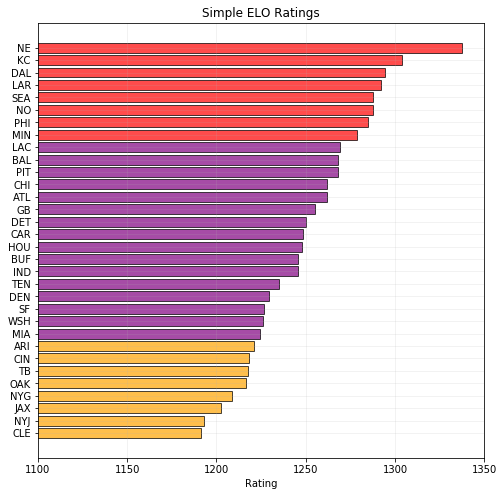

In [84]:
plot_rankings(current_ratings)